In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import pathlib

In [5]:
folder = './244146_847361_bundle_archive'
data_dir = pathlib.Path(folder)

In [6]:
from __future__ import print_function
import os, sys
from PIL import Image

In [ ]:
for dir in os.listdir(folder):
  # print(dir)
  if dir != 'README':
    for filename in os.listdir(folder+'/'+dir):
      # print(filename)
      f, e = os.path.splitext(filename)
      outfile = folder + '/' + dir + '/' + f + ".jpg"
      infile = folder + '/' + dir + '/' + filename
      if infile != outfile:
          try:
              Image.open(infile).save(outfile)
          except IOError:
              print("cannot convert", infile)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

400


In [8]:
print(data_dir)

244146_847361_bundle_archive


In [9]:
import PIL
from PIL import Image
import os

In [10]:
fp = os.path.join(data_dir, 's1/2.jpg')

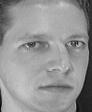

In [11]:
Image.open(fp)
# im.show()

# using tf.data

In [12]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.jpg'), shuffle = True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration = False)

In [13]:
for f in list_ds.take(5):
  print(f.numpy())

b'244146_847361_bundle_archive/s25/10.jpg'
b'244146_847361_bundle_archive/s40/6.jpg'
b'244146_847361_bundle_archive/s33/5.jpg'
b'244146_847361_bundle_archive/s21/5.jpg'
b'244146_847361_bundle_archive/s28/8.jpg'


In [14]:
import numpy as np

In [15]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'README']))
print(class_names)

['s1' 's10' 's11' 's12' 's13' 's14' 's15' 's16' 's17' 's18' 's19' 's2'
 's20' 's21' 's22' 's23' 's24' 's25' 's26' 's27' 's28' 's29' 's3' 's30'
 's31' 's32' 's33' 's34' 's35' 's36' 's37' 's38' 's39' 's4' 's40' 's5'
 's6' 's7' 's8' 's9']


In [16]:
test_size = int(image_count * 0.2)
training_ds = list_ds.skip(test_size)
test_ds = list_ds.take(test_size)

In [17]:
val_size = int(image_count * 0.2)
train_ds = training_ds.skip(val_size)
val_ds = training_ds.take(val_size)

In [18]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

240
80
80


In [19]:
def get_label(fp):
  parts = tf.strings.split(fp, os.path.sep)
  one_hot = parts[-2]==class_names
  return tf.argmax(one_hot)

In [20]:
batch_size = 16
img_height = 92
img_width = 112
def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [img_height, img_width])

In [21]:
def process_path(fp):
  label = get_label(fp)
  img = tf.io.read_file(fp)
  img = decode_img(img)
  return img, label

In [22]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [23]:
for img, label in train_ds.take(1):
  print(img.numpy().shape)
  print(label.numpy())

(92, 112, 3)
15


In [24]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=100)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [25]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(40)
])

In [26]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)

Epoch 1/15
15/15 [==============================] - 4s 261ms/step - loss: 3.7220 - accuracy: 0.0250 - val_loss: 3.6833 - val_accuracy: 0.0500
Epoch 2/15
15/15 [==============================] - 3s 180ms/step - loss: 3.6833 - accuracy: 0.0375 - val_loss: 3.6751 - val_accuracy: 0.0875
Epoch 3/15
15/15 [==============================] - 3s 180ms/step - loss: 3.6602 - accuracy: 0.0542 - val_loss: 3.6588 - val_accuracy: 0.0375
Epoch 4/15
15/15 [==============================] - 3s 183ms/step - loss: 3.5906 - accuracy: 0.0542 - val_loss: 3.5472 - val_accuracy: 0.1875
Epoch 5/15
15/15 [==============================] - 3s 182ms/step - loss: 3.3514 - accuracy: 0.2042 - val_loss: 3.0797 - val_accuracy: 0.3000
Epoch 6/15
15/15 [==============================] - 3s 183ms/step - loss: 2.6463 - accuracy: 0.3542 - val_loss: 2.3865 - val_accuracy: 0.4250
Epoch 7/15
15/15 [==============================] - 3s 184ms/step - loss: 1.5838 - accuracy: 0.6750 - val_loss: 1.4217 - val_accuracy: 0.6625
Epoch 

In [28]:
loss, acc = model.evaluate(test_ds)
print("test accuracy:", acc)

5/5 [==============================] - 0s 45ms/step - loss: 0.2406 - accuracy: 0.9500
test accuracy: 0.949999988079071
